Enter Bins in Radial direction: 720
Enter Username: jthompson
Enter Password: ········
Enter Database: MTSO
(177, 756556)
There are 177 stars in bin 756556 which is located at (62.8125,65.0149253731)


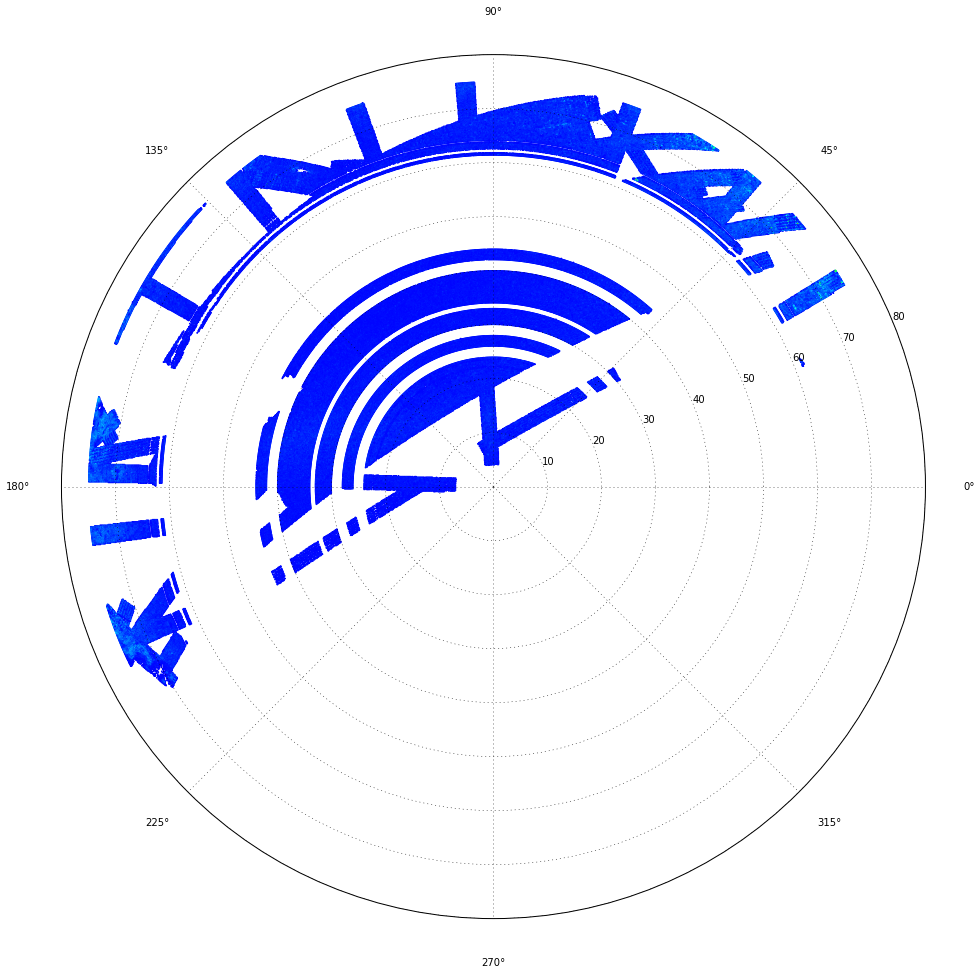

Done


In [1]:
%matplotlib inline
import MySQLdb
import sys
import getpass
import matplotlib.pyplot as plt
import matplotlib.colors as color
import numpy as np

# create color map
# This algorithm came was derived from reading https://www.particleincell.com/2014/colormap/
def data_bin (row, theta, delta_r):
    r = 90.0 - np.abs(row)
    theta = np.pi/180.0*theta
    row = int(r/delta_r)
    tbin = int(theta/(2*np.pi)*(6*row+3))
    return 3*row**2 + tbin   

def normalColor (count, cmin, cmax, style ='linear'):
    if style == 'linear':
        normal = float(count - cmin)/float(cmax - cmin)
    elif style == 'log':
        normal = np.exp(float(count - cmin)/float(cmax - cmin)
    )**np.log(2)-1
    elif style == 'exp':
        normal = np.log(float(count - cmin)/float(cmax - cmin)
    )/np.log(2)
    elif style == 'ceiling':
        if count > 256:
            count = 256
        cmax = 256
        cmin = 1
        normal = float(float(count - cmin)/float(cmax - cmin))
    
    a = float(1.0 - normal)/(0.25)
    x = np.floor(a)
    y = a-x
    r = 1.0
    g = 1.0
    b = 1.0
    
    if normal == 0:
        r, g, b = (1.0, 1.0, 1.0)
    elif normal == 1:
        r, g, b = (0.0, 0.0, 0.0)
    elif int(x) == 0:
        r, g, b = (1.0, y, 0.0)
    elif int(x) == 1:
        r, g, b = (r - y, 1.0, 0.0)
    elif int(x) == 2:
        r, g, b = (0.0, 1.0, y)
    elif int(x)== 3:
        r, g, b = (0.0, g - y, 1.0)
    elif int(x) == 4:
        r, g, b = (0.0, 0.0, 1.0)
    else:
        r, g, b = (0.0, 0.0, 0.0)
    return [r, g, b]

# bin properties
no_r_bins = int(raw_input('Enter Bins in Radial direction: '))
radius = 90                     # number of r sized bins in the radial direction
delta_r = radius/float(no_r_bins)   # we use a unit size for the bin
no_bins = 3*no_r_bins**2            # total number of bins
bins = {0:0}

# create bin boundaries
fig = plt.figure(num=None, figsize=(15, 15), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
#ax.set_rticks([90, 45, 0.0])
# Read Data from the Database

user = raw_input('Enter Username: ')
passwd =  getpass.getpass('Enter Password: ')
mydb = raw_input('Enter Database: ')

# Open database connection

db = MySQLdb.connect(host='localhost',
    user= user,
    passwd= passwd,
    db= mydb)
    
# prepare a cursor object using cursor() method

cursor = db.cursor()

query = "select l, b from sdss_dr_12_v_1_0_2"

try:
    # Execute the SQL command
    cursor.execute(query)
    # Fetch all the rows in a list of lists.
    results = cursor.fetchall()
    for row in results:
        theta = row[0]
        r = row[1]
        bin_no = data_bin(r, theta, delta_r)
        if bins.has_key(bin_no):
            bins[bin_no]+=1
        else:
            bins[bin_no] = 1
        
except:
   print "Error: unable to fecth data"
import operator

# disconnect from server
db.close()

minCount = 0
maxCount, maxBin =  max(zip(bins.values(), bins.keys()))
row = int(np.ceil(np.sqrt(int(maxBin/3+1))))
delta_theta = (2.0*np.pi)/float((6*(row)-3))
theta_bin = maxBin - 3*(row-1)**2
r_min = (row-1)*delta_r
r_max = row*delta_r
rAv = (r_max+r_min)/2.0
theta_min = theta_bin * delta_theta
theta_max = theta_min + delta_theta
thetaAv = (180.0/np.pi)*(theta_max+theta_min)/2.0
print max(zip(bins.values(), bins.keys()))
print "There are {0} stars in bin {1} which is located at ({2},{3})".format(maxCount, maxBin, rAv, thetaAv)
for bin_no, count in bins.iteritems():
    row = int(np.ceil(np.sqrt(int(bin_no/3+1))))
    delta_theta = (2.0*np.pi)/float((6*(row)-3))
    theta_bin = bin_no - 3*(row-1)**2
    r_min = (row-1)*delta_r
    r_max = row*delta_r
    theta_min = theta_bin * delta_theta
    theta_max = theta_min + delta_theta
    theta = np.arange(theta_min, theta_max, 1.0/(4*no_r_bins))
    r_1 = r_min + 0*theta
    r_2 = r_max + 0*theta
    scolor = normalColor(count, minCount, maxCount, style ="log")
    plt.fill_between(theta, r_1, r_2, color=scolor, interpolate = True)
plt.show()
print "Done"